Chapter 2
======
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

`Ported to PyMC last by Kurisu Chan (@miemiekurisu)`

___

This notebook introduces the core concepts of **NumPyro**, a lightweight probabilistic programming library built on top of **JAX**. We'll cover model contexts, how to define stochastic and deterministic variables, incorporate observed data, and leverage JAX's functionality through NumPyro for efficient and scalable Bayesian inference. It also contains tips and data visualization techniques for assessing goodness-of-fit for your Bayesian model.

## More on NumPyro

### Model Functions

In NumPyro, models are defined as regular Python functions. Inside a model function, we use `numpyro.sample()` to define **stochastic** variables, and `numpyro.deterministic()` for **deterministic** ones.

Unlike global-state probabilistic programming frameworks, NumPyro requires that you explicitly pass PRNG keys and use handlers to simulate or perform inference.

Let's start with a simple model definition.

In [2]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive

rng_key = jrandom.PRNGKey(8927)


# Define a simple model with both stochastic and deterministic variables
def model():
    # Exponential prior over a Poisson rate parameter
    rate = numpyro.sample("poisson_rate", dist.Exponential(1.0))

    # Deterministic transformation for interpretability or tracking. Since we're using `deterministic`,
    # this variable will be traced and saved for later.
    rate_plus_one = numpyro.deterministic("rate_plus_one", rate + 1)

    # Poisson likelihood using the original rate
    observation = numpyro.sample("obs", dist.Poisson(rate), obs=jnp.array([12]))


To inspect the model structure, we can use handlers like `trace`. For every variable it tracks the name, the distribution it was drawn from, the sampled value and other useful data. It's useful at the beginning of the modeling process, to verify things work as intended.

In [3]:
model_trace = trace(seed(model, rng_key)).get_trace()
print(model_trace)

OrderedDict({'poisson_rate': {'type': 'sample', 'name': 'poisson_rate', 'fn': <numpyro.distributions.continuous.Exponential object at 0x7f349016dfd0 with batch shape () and event shape ()>, 'args': (), 'kwargs': {'rng_key': Array([2079454497, 2029875941], dtype=uint32), 'sample_shape': ()}, 'value': Array(0.26048967, dtype=float32), 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}, 'rate_plus_one': {'type': 'deterministic', 'name': 'rate_plus_one', 'value': Array(1.2604897, dtype=float32), 'cond_indep_stack': []}, 'obs': {'type': 'sample', 'name': 'obs', 'fn': <numpyro.distributions.discrete.Poisson object at 0x7f33b43323f0 with batch shape () and event shape ()>, 'args': (), 'kwargs': {'rng_key': None, 'sample_shape': ()}, 'value': Array([12], dtype=int32), 'scale': None, 'is_observed': True, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}})


NumPyro models are defined as Python functions. Within these functions, we use two main primitives:

- `numpyro.sample(name, distribution, obs=None)`  
  This defines a **stochastic random variable**. If `obs` is `None`, the variable is treated as **latent** (unknown and to be inferred). If `obs` is provided, the variable is **observed** and treated as known data - this effectively conditions the model on the data.
  
- `numpyro.deterministic(name, expression)`  
  This defines a **deterministic variable**, that is a value that is computed from other variables and tracked during inference. These are helpful for saving intermediate values, especially if they help interpret the posterior or aid debugging. For example, if you write `a = numpyro.sample(...)` and then compute `b = a + 1`, the variable `b` exists only locally and won’t be included in the model trace. By using `numpyro.deterministic("b", a + 1)`, you ensure that `b` is recorded and accessible in posterior or predictive analysis.


By convention, a NumPyro model does not need to return any value - everything needed for inference is captured in the internal trace built during sampling. However, returning values (e.g. intermediate calculations or predictions) can be helpful for predictive sampling (using `Predictive`) or debugging.

### Running Inference with MCMC

Once we've defined a model, we can run inference using `MCMC` with a chosen kernel (e.g., `NUTS`). We'll cover this in more detail in Chapter 3. For now, it's enough to know that `MCMC` allows us to approximate the posterior distribution of model parameters given the observed data. it helps us learn what parameter values are likely, and how uncertain we are about them.

Here’s how to run inference and view posterior samples:

In [4]:
# Run inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key)

# This is a dict. Samples for each variable defined with `.sample` or `.deterministic` are in this dict.
posterior_samples = mcmc.get_samples()

mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:08<00:00, 169.22it/s, 3 steps of size 1.25e+00. acc. prob=0.88]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  poisson_rate      6.34      1.89      6.11      3.25      9.14    427.26      1.00

Number of divergences: 0


Let’s take a look at the prior distribution by drawing samples directly from it (without data), and then compare with posterior distributions from the inference run.

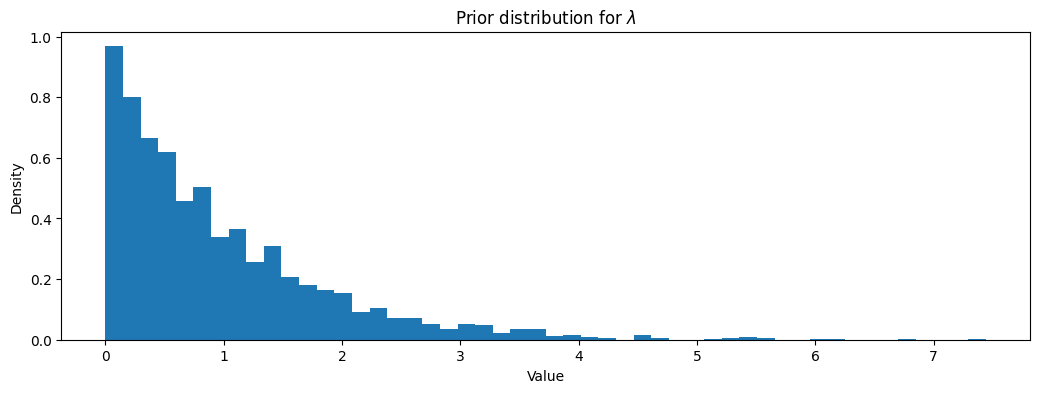

In [5]:
prior = Predictive(model, num_samples=2000)
prior_samples = prior(rng_key)


fig, ax = plt.subplots(figsize=(12.5, 4))
ax.hist(prior_samples["poisson_rate"], bins=50, density=True)
ax.set_title("Prior distribution for $\\lambda$")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
plt.show()

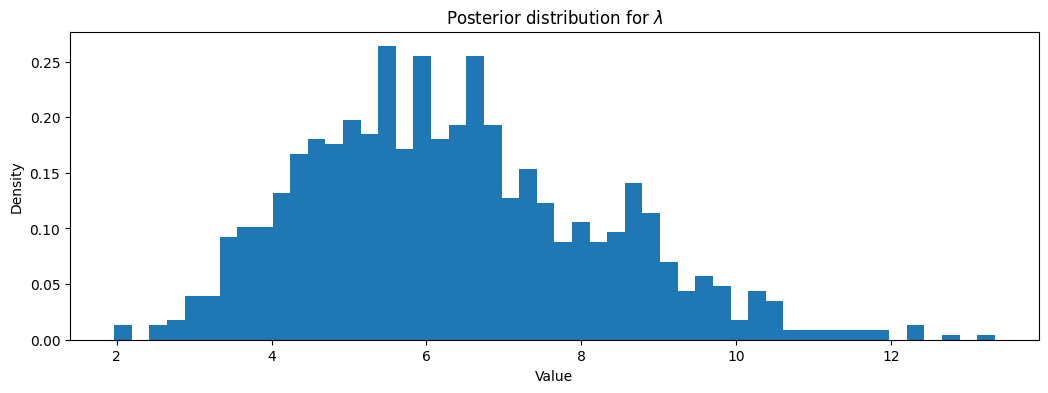

In [6]:
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.hist(posterior_samples["poisson_rate"], bins=50, density=True)
ax.set_title("Posterior distribution for $\\lambda$")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
plt.show()

### Vectorized Parameters with `shape`

NumPyro supports defining multiple independent variables by specifying the `shape` argument.

This is useful when modeling arrays of parameters like $\beta_1, \beta_2, ..., \beta_N$.


In [7]:
def vec_model():
    betas = numpyro.sample("betas", dist.Uniform(0, 1).expand([5]))
    numpyro.deterministic("mean_beta", jnp.mean(betas))


vec_model_trace = trace(seed(vec_model, rng_key)).get_trace()
print(vec_model_trace)

OrderedDict({'betas': {'type': 'sample', 'name': 'betas', 'fn': <numpyro.distributions.distribution.ExpandedDistribution object at 0x7f3327159370 with batch shape (5,) and event shape ()>, 'args': (), 'kwargs': {'rng_key': Array([2079454497, 2029875941], dtype=uint32), 'sample_shape': ()}, 'value': Array([0.22932589, 0.83749497, 0.04111993, 0.4332223 , 0.8978102 ],      dtype=float32), 'scale': None, 'is_observed': False, 'intermediates': [], 'cond_indep_stack': [], 'infer': {}}, 'mean_beta': {'type': 'deterministic', 'name': 'mean_beta', 'value': Array(0.4877947, dtype=float32), 'cond_indep_stack': []}})


### NumPyro and JAX Operations

All array operations inside models must use **JAX** functions, like `jax.numpy` instead of regular NumPy.

This enables automatic differentiation, JIT compilation, and vectorized execution.


In [8]:
def jax_ops_model():
    x = numpyro.sample("x", dist.Normal(0, 1))
    y = numpyro.deterministic("y", jnp.exp(x) + jnp.sin(x))

## Modeling approaches

A good starting thought to Bayesian modeling is to think about *how your data might have been generated*. Position yourself in an omniscient position, and try to imagine how *you* would recreate the dataset. 

In the last chapter we investigated text message data. We begin by asking how our observations may have been generated:

1.  We started by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of sms's received as sampled from a Poisson distribution.

2.  Next, we think, "Ok, assuming sms's are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier behaviour and one for the later behaviour. We don't know when the behaviour switches though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 10 and 30", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$s are between 10-30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. This was shown in the last chapter.

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.


Below we give a graphical visualization of this, where arrows denote `parent-child` relationships. (provided by the [Daft Python library](https://docs.daft-pgm.org/en/latest/) )

<img src="http://i.imgur.com/7J30oCG.png" width = 700/>


PyMC, NumPyro and other probabilistic programming languages, have been designed to tell these data-generation *stories*. More generally, B. Cronin writes [5]:

> Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

### Same story; different ending.

Interestingly, we can create *new datasets* by retelling the story.
For example, if we reverse the above steps, we can simulate a possible realization of the dataset.

1\. Specify when the user's behaviour switches by sampling from $\text{DiscreteUniform}(0, 80)$:

In [13]:
key = jrandom.PRNGKey(18)
tau = dist.DiscreteUniform(0, 80).sample(key)
print(tau)

77


2\. Draw $\lambda_1$ and $\lambda_2$ from an $\text{Exp}(\alpha)$ distribution:

In [14]:
key, subkey1, subkey2 = jrandom.split(key, 3)
alpha = 1.0 / 20.0
lambda_1 = dist.Exponential(alpha).sample(subkey1)
lambda_2 = dist.Exponential(alpha).sample(subkey2)
print(lambda_1, lambda_2)

93.91648 10.607792


3\.  For days before $\tau$, represent the user's received SMS count by sampling from $\text{Poi}(\lambda_1)$, and sample from  $\text{Poi}(\lambda_2)$ for days after $\tau$. For example:

In [15]:
key, subkey1, subkey2 = jrandom.split(key, 3)

data_part1 = dist.Poisson(lambda_1).sample(subkey1, sample_shape=(tau,))
data_part2 = dist.Poisson(lambda_2).sample(subkey2, sample_shape=(80 - tau,))
data = jnp.concatenate([data_part1, data_part2])

4\. Plot the artificial dataset:

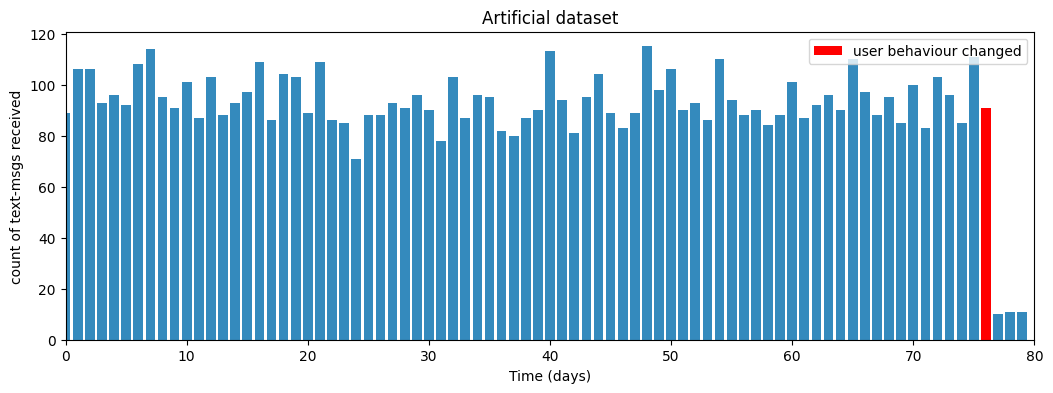

In [16]:
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.bar(np.arange(80), data, color="#348ABD")
ax.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
ax.set_xlabel("Time (days)")
ax.set_ylabel("count of text-msgs received")
ax.set_title("Artificial dataset")
ax.set_xlim(0, 80)
ax.legend()
plt.show()

It is okay that our fictional dataset does not look like our observed dataset: the probability is incredibly small it indeed would. PyMC's engine is designed to find good parameters, $\lambda_i, \tau$, that maximize this probability.  


The ability to generate artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. We produce a few more datasets below:

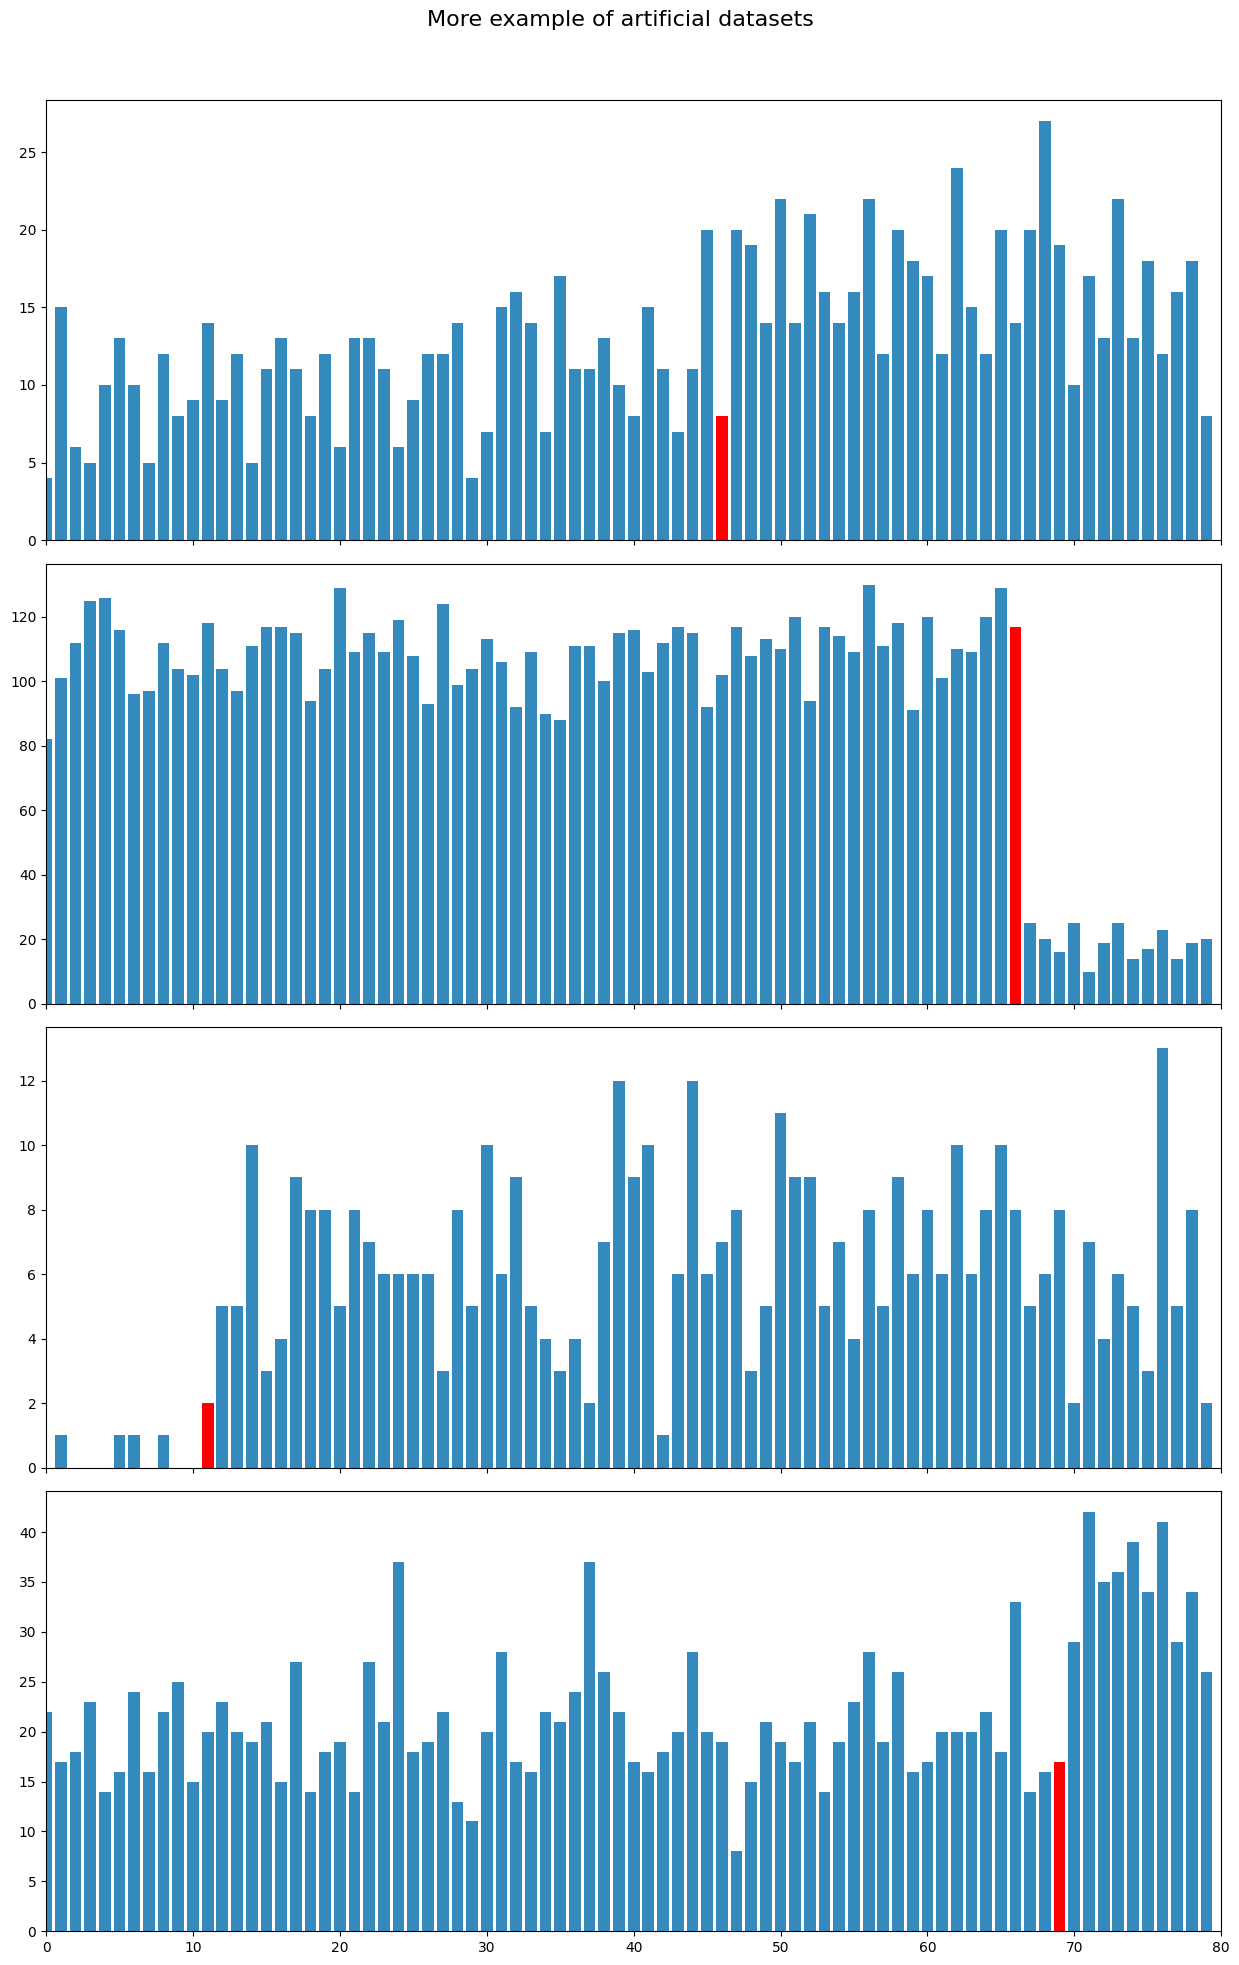

In [17]:
def plot_artificial_sms_dataset(ax, key):
    key_tau, key_exp1, key_exp2, key_p1, key_p2 = jrandom.split(key, 5)
    tau = jrandom.randint(key_tau, shape=(), minval=0, maxval=80)
    alpha = 1.0 / 20.0
    lambda_1 = dist.Exponential(alpha).sample(key_exp1)
    lambda_2 = dist.Exponential(alpha).sample(key_exp2)
    data_part1 = dist.Poisson(lambda_1).sample(key_p1, sample_shape=(tau,))
    data_part2 = dist.Poisson(lambda_2).sample(key_p2, sample_shape=(80 - tau,))
    data = jnp.concatenate([data_part1, data_part2])

    ax.bar(jnp.arange(80), data, color="#348ABD")
    ax.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
    ax.set_xlim(0, 80)


fig, axes = plt.subplots(4, 1, figsize=(12.5, 5 * 4), sharex=True)
fig.suptitle("More example of artificial datasets", fontsize=16)

for i, ax in enumerate(axes):
    key = jrandom.PRNGKey(i + 1)
    plot_artificial_sms_dataset(ax, key)

plt.tight_layout(rect=[0, 0, 1, 0.96])

Later we will see how we use this to make predictions and test the appropriateness of our models.

##### Example: Bayesian A/B testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results. 

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards. 

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily *learned* this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural. 

### A Simple Case

As this is a hacker book, we'll continue with the web-dev example. For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [18]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS


def model_A(n_obs, N_total):
    p = numpyro.sample("p", dist.Uniform(0, 1))
    numpyro.sample("obs", dist.Binomial(total_count=N_total, probs=p), obs=n_obs)


Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [19]:
# simulate data
key = jrandom.PRNGKey(0)
p_true = 0.05
N = 1500
occurrences = dist.Bernoulli(probs=p_true).sample(key, sample_shape=(N,))
print(occurrences)
print(jnp.sum(occurrences))

[0 0 0 ... 1 0 0]
82


The observed frequency is:

In [20]:
# Occurrences.mean is equal to n/N.
print(f"What is the observed frequency in Group A? {jnp.mean(occurrences):0.4f}")
print(f"Does this equal the true frequency? {jnp.mean(occurrences) == p_true}")

What is the observed frequency in Group A? 0.0547
Does this equal the true frequency? False


We combine the observations into the PyMC `observed` variable, and run our inference algorithm:

In [23]:
# run MCMC for A only
rng_key = random.PRNGKey(0)
n_obs = jnp.sum(occurrences)

kernel = NUTS(model_A)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=3)
mcmc.run(rng_key, n_obs=n_obs, N_total=N)
posterior_samples = mcmc.get_samples()

/tmp/ipykernel_20002/3382645236.py:6: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=3)
sample: 100%|██████████| 4000/4000 [00:19<00:00, 206.13it/s, 1 steps of size 1.06e+00. acc. prob=0.92]


We plot the posterior distribution of the unknown $p_A$ below:

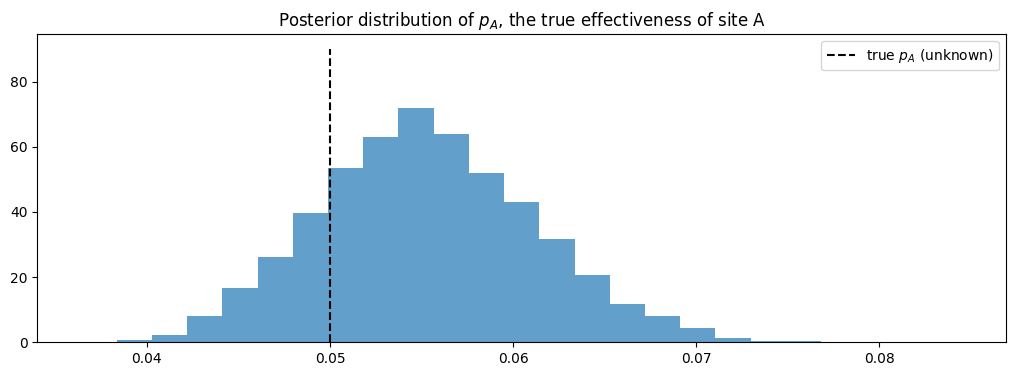

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)", color="black")
plt.hist(posterior_samples["p"], bins=25, density=True, alpha=0.7)
plt.legend()
plt.show()


Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. This is a measure of how uncertain we should be, given our observations. Try changing the number of observations, `N`, and observe how the posterior distribution changes.


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

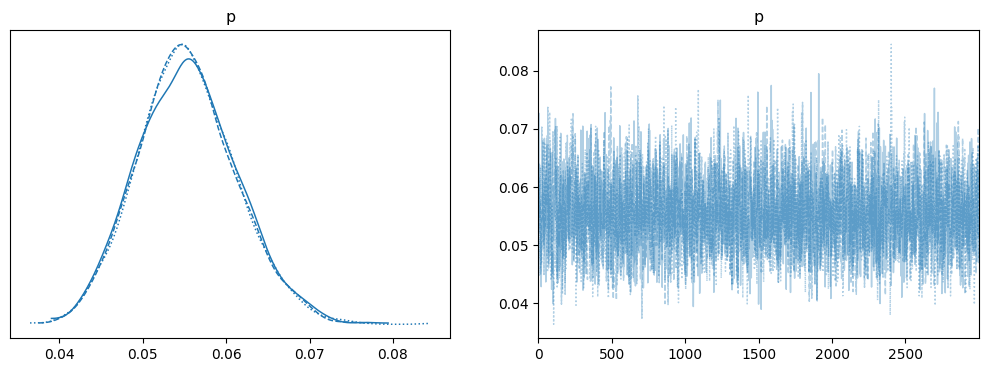

In [25]:
import arviz as az

idata = az.from_numpyro(mcmc)
az.plot_trace(idata, var_names=["p"], figsize=(12.5, 4))


We can clearly see the three independent chains left above.

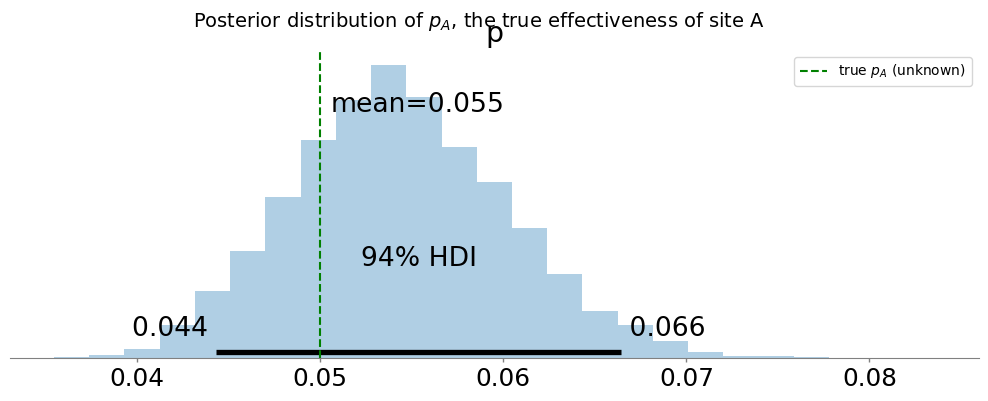

In [26]:
import arviz as az
import matplotlib.pyplot as plt

idata = az.from_numpyro(mcmc)

ax = az.plot_posterior(idata, var_names=["p"], kind="hist", bins=25, figsize=(12.5, 4))
plt.suptitle("Posterior distribution of $p_A$, the true effectiveness of site A", fontsize=14)
plt.axvline(0.05, color="green", linestyle="--", label="true $p_A$ (unknown)")
plt.legend()
plt.show()



### *A* and *B* Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using PyMC's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data )

In [27]:
# simulate data for A and B
true_p_A = 0.05
true_p_B = 0.04


N_A = 1500
N_B = 750


# PRNG keys for reproducibility
rng_key = jrandom.PRNGKey(0)
key_A, key_B = jrandom.split(rng_key)

# Generate some observations using NumPyro's Bernoulli distribution
observations_A = dist.Bernoulli(probs=true_p_A).sample(key_A, sample_shape=(N_A,))
observations_B = dist.Bernoulli(probs=true_p_B).sample(key_B, sample_shape=(N_B,))

print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")
print(jnp.mean(observations_A))
print(jnp.mean(observations_B))


Obs from Site A:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] ...
Obs from Site B:  [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] ...
0.05733333
0.052


In [28]:
def model_ab(n_A, N_A, n_B, N_B):
    p_A = numpyro.sample("p_A", dist.Uniform(0, 1))
    p_B = numpyro.sample("p_B", dist.Uniform(0, 1))
    delta = numpyro.deterministic("delta", p_A - p_B)

    numpyro.sample("obs_A", dist.Binomial(total_count=N_A, probs=p_A), obs=n_A)
    numpyro.sample("obs_B", dist.Binomial(total_count=N_B, probs=p_B), obs=n_B)


In [29]:
rng_key = random.PRNGKey(2)
n_A = jnp.sum(observations_A)
n_B = jnp.sum(observations_B)

kernel = NUTS(model_ab)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000)
mcmc.run(rng_key, n_A=n_A, N_A=N_A, n_B=n_B, N_B=N_B)
posterior = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:40<00:00, 147.16it/s, 1 steps of size 8.71e-01. acc. prob=0.91] 


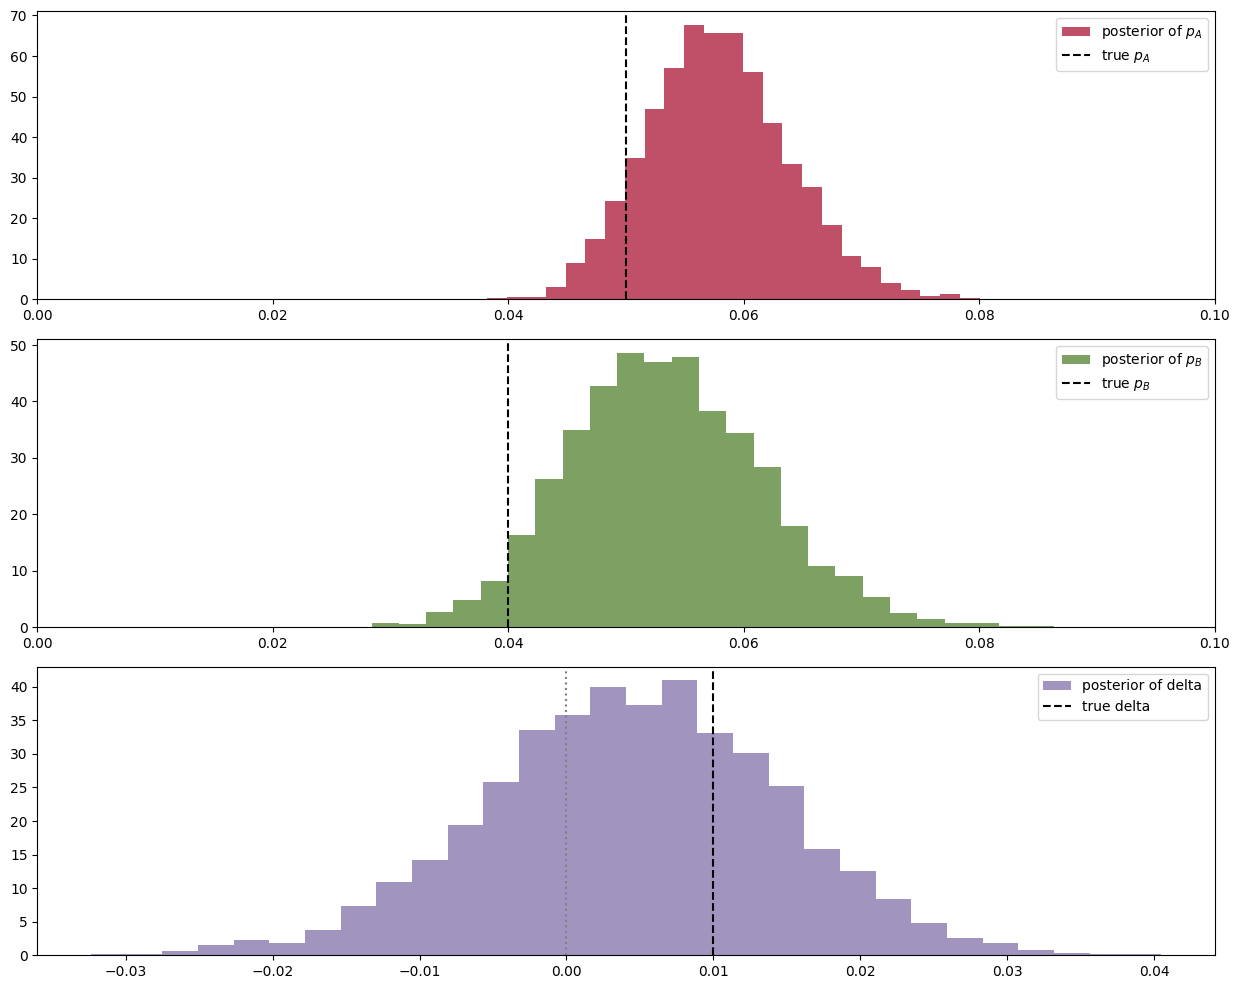

In [30]:
p_A_samples = posterior["p_A"]
p_B_samples = posterior["p_B"]
delta_samples = posterior["delta"]

plt.figure(figsize=(12.5, 10))

plt.subplot(311)
plt.hist(p_A_samples, bins=25, density=True, alpha=0.7, label="posterior of $p_A$", color="#A60628")
plt.axvline(true_p_A, linestyle="--", label="true $p_A$", color="black")
plt.xlim(0, 0.1)
plt.legend()

plt.subplot(312)
plt.hist(p_B_samples, bins=25, density=True, alpha=0.7, label="posterior of $p_B$", color="#467821")
plt.axvline(true_p_B, linestyle="--", label="true $p_B$", color="black")
plt.xlim(0, 0.1)
plt.legend()

plt.subplot(313)
plt.hist(delta_samples, bins=30, density=True, alpha=0.7, label="posterior of delta", color="#7A68A6")
plt.axvline(true_p_A - true_p_B, linestyle="--", label="true delta", color="black")
plt.axvline(0, color="gray", linestyle=":")
plt.legend()

plt.tight_layout()
plt.show()


Notice that as a result of `N_B < N_A`, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$.  

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, implying there site A's response is likely better than site B's response. The probability this inference is incorrect is easily computable:

In [31]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % jnp.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % jnp.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.322
Probability site A is BETTER than site B: 0.678


If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A). 

Try playing with the parameters `true_p_A`, `true_p_B`, `N_A`, and `N_B`, to see what the posterior of $\text{delta}$ looks like. Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.

I hope the readers feel this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. Later in this book, we will see two extensions of this model: the first to help dynamically adjust for bad sites, and the second will improve the speed of this computation by reducing the analysis to a single equation.   

## An algorithm for human deceit

Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie *only* about *not cheating*; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated). 

To present an elegant solution to circumventing this dishonesty problem, and to demonstrate Bayesian modeling, we first need to introduce the binomial distribution.

### The Binomial Distribution

The binomial distribution is one of the most popular distributions, mostly because of its simplicity and usefulness. Unlike the other distributions we have encountered thus far in the book, the binomial distribution has 2 parameters: $N$, a positive integer representing $N$ trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. Like the Poisson distribution, it is a discrete distribution, but unlike the Poisson distribution, it only weighs integers from $0$ to $N$. The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin}(N,p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$ is (while still remaining between 0 and 1), the more events are likely to occur. The expected value of a binomial is equal to $Np$. Below we plot the mass probability distribution for varying parameters. 


Text(0.5, 1.0, 'Probability mass distributions of binomial random variables')

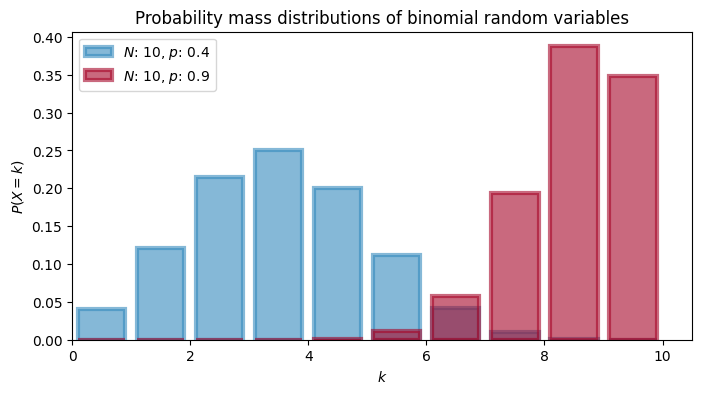

In [32]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro.distributions as dist

fig, ax = plt.subplots(figsize=(8, 4))

parameters = [(10, 0.4), (10, 0.9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)

    pmf = jnp.exp(dist.Binomial(N, p).log_prob(_x))

    ax.bar(
        _x - 0.5,
        pmf,
        color=colors[i],
        edgecolor=colors[i],
        alpha=0.6,
        label=f"$N$: {N}, $p$: {p:.1f}",
        linewidth=3,
    )

ax.legend(loc="upper left")
ax.set_xlim(0, 10.5)
ax.set_xlabel("$k$")
ax.set_ylabel("$P(X = k)$")
ax.set_title("Probability mass distributions of binomial random variables")

The special case when $N = 1$ corresponds to the Bernoulli distribution. There is another connection between Bernoulli and Binomial random variables. If we have $X_1, X_2, ... , X_N$ Bernoulli random variables with the same $p$, then $Z = X_1 + X_2 + ... + X_N \sim \text{Binomial}(N, p )$.

The expected value of a Bernoulli random variable is $p$. This can be seen by noting the more general Binomial random variable has expected value $Np$ and setting $N=1$.

##### Example: Cheating among students

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let $N$ be the total number of students who took the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer $X$ "Yes I did cheat" answers. We then find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$. 

This is a completely absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better *algorithm* to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a solution I greatly admire for its ingenuity and effectiveness:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers. 

I call this the Privacy Algorithm. One could of course argue that the interviewers are still receiving false data since some *Yes*'s are not confessions but instead randomness, but an alternative perspective is that the researchers are discarding approximately half of their original dataset since half of the responses will be noise. But they have gained a systematic data generation process that can be modeled. Furthermore, they do not have to incorporate (perhaps somewhat naively) the possibility of deceitful answers. We can use PyMC to dig through this noisy model, and find a posterior distribution for the true frequency of liars. 

Suppose 100 students are being surveyed for cheating, and we wish to find $p$, the proportion of cheaters. There are a few ways we can model this in PyMC. I'll demonstrate the most explicit way, and later show a simplified version. Both versions arrive at the same inference. In our data-generation model, we sample $p$, the true proportion of cheaters, from a prior. Since we are quite ignorant about $p$, we will assign it a $\text{Uniform}(0,1)$ prior.  

Again, thinking of our data-generation model, we assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not.  

If we carry out the algorithm, the next step that occurs is the first coin-flip each student makes. This can be modeled again by sampling 100 Bernoulli random variables with $p=1/2$: denote a 1 as a *Heads* and 0 a *Tails*.  

Although *not everyone* flips a second time, we can still model the possible realization of second coin-flips.

Using these variables, we can return a possible realization of the *observed proportion* of "Yes" responses. We do this using a NumPyro `deterministic`.  

The line `fc*t_a + (1-fc)*sc` contains the heart of the Privacy algorithm. Elements in this array are 1 *if and only if* i) the first toss is heads and the student cheated or ii) the first toss is tails, and the second is heads, and are 0 else. Finally, the last line sums this vector and divides by `float(N)`, produces a proportion. 

In [35]:
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro import deterministic, sample

# Number of students
N = 100
X = 35
# PRNG key
rng_key = random.PRNGKey(0)


def randomized_response_model():
    # Prior for frequency of cheating
    p = sample("freq_cheating", dist.Uniform(0, 1))

    # True answers (1 = cheated, 0 = didn't cheat)
    true_answers = sample("truths", dist.Bernoulli(p).expand([N]))

    # First coin flips
    first_coin_flips = sample("first_flips", dist.Bernoulli(0.5).expand([N]))

    # Second coin flips
    second_coin_flips = sample("second_flips", dist.Bernoulli(0.5).expand([N]))

    # Observed "yes" responses
    val = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips
    observed_proportion = deterministic("observed_proportion", jnp.sum(val) / float(N))

    # Likelihood of observed number of "Yes" answers
    sample("obs", dist.Binomial(total_count=N, probs=observed_proportion), obs=X)


nuts_kernel = DiscreteHMCGibbs(NUTS(randomized_response_model))
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = jrandom.PRNGKey(0)
mcmc.run(rng_key)
posterior_samples = mcmc.get_samples()


sample: 100%|██████████| 1500/1500 [02:01<00:00, 12.32it/s, 1 steps of size 5.27e-01. acc. prob=0.86]


Next we need a dataset. After performing our coin-flipped interviews the researchers received 35 "Yes" responses. To put this into a relative perspective, if there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat-free world. On the other hand, if *all students cheated*, we should expected to see approximately 3/4 of all responses be "Yes". 

The researchers observe a Binomial random variable, with `N = 100` and `p = observed_proportion` with `value = 35`:  

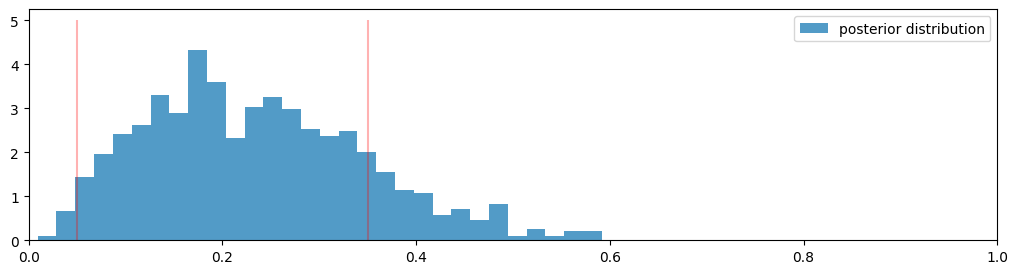

In [37]:
fig, ax = plt.subplots(figsize=(12.5, 3))
ax.hist(
    posterior_samples["freq_cheating"],
    bins=30,
    density=True,
    alpha=0.85,
    color="#348ABD",
    histtype="stepfilled",
    label="posterior distribution",
)
ax.vlines([0.05, 0.35], 0, 5, color="red", alpha=0.3)
ax.set_xlim(0, 1)
ax.legend()

With regards to the above plot, we are still pretty uncertain about what the true frequency of cheaters might be, but we have narrowed it down to a range between 0.05 to 0.35 (marked by the solid lines). This is pretty good, as *a priori* we had no idea how many students might have cheated (hence the uniform distribution for our prior). On the other hand, it is also pretty bad since there is a .3 length window the true value most likely lives in. Have we even gained anything, or are we still too uncertain about the true frequency? 

I would argue, yes, we have discovered something. It is implausible, according to our posterior, that there are *no cheaters*, i.e. the posterior assigns low probability to $p=0$. Since we started with an uniform prior, treating all values of $p$ as equally plausible, but the data ruled out $p=0$ as a possibility, we can be confident that there were cheaters. 

This kind of algorithm can be used to gather private information from users and be *reasonably* confident that the data, though noisy, is truthful. 



### Alternative PyMC Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes: 

\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

Thus, knowing $p$ we know the probability a student will respond "Yes". In PyMC, we can create a deterministic function to evaluate the probability of responding "Yes", given $p$:

sample: 100%|██████████| 27500/27500 [03:18<00:00, 138.37it/s, 3 steps of size 6.41e-01. acc. prob=0.94] 


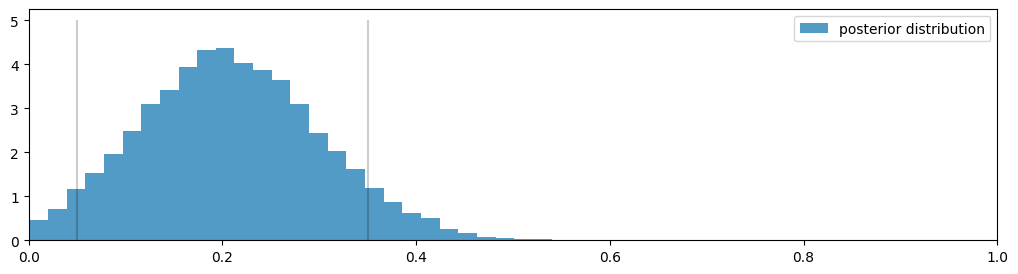

In [39]:
# Constants
N = 100
X = 35


def simple_skewed_model():
    # Prior on true cheating rate
    p = sample("freq_cheating", dist.Uniform(0.0, 1.0))

    # Deterministic transformation
    p_skewed = deterministic("p_skewed", 0.5 * p + 0.25)

    # Likelihood of observed number of "Yes" answers
    sample("number_cheaters", dist.Binomial(total_count=N, probs=p_skewed), obs=X)


# Run MCMC
nuts_kernel = NUTS(simple_skewed_model)
mcmc = MCMC(nuts_kernel, num_warmup=2500, num_samples=25000)
rng_key = jrandom.PRNGKey(0)
mcmc.run(rng_key)
posterior_samples = mcmc.get_samples()

# Plotting posterior
fig, ax = plt.subplots(figsize=(12.5, 3))
ax.hist(
    posterior_samples["freq_cheating"],
    bins=30,
    density=True,
    alpha=0.85,
    color="#348ABD",
    histtype="stepfilled",
    label="posterior distribution",
)
ax.vlines([0.05, 0.35], 0, 5, color="black", alpha=0.2)
ax.set_xlim(0, 1)
ax.legend()



##### Example: Challenger Space Shuttle Disaster <span id="challenger"/>

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):





Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


Text(0.5, 1.0, 'Defects of the Space Shuttle O-Rings vs temperature')

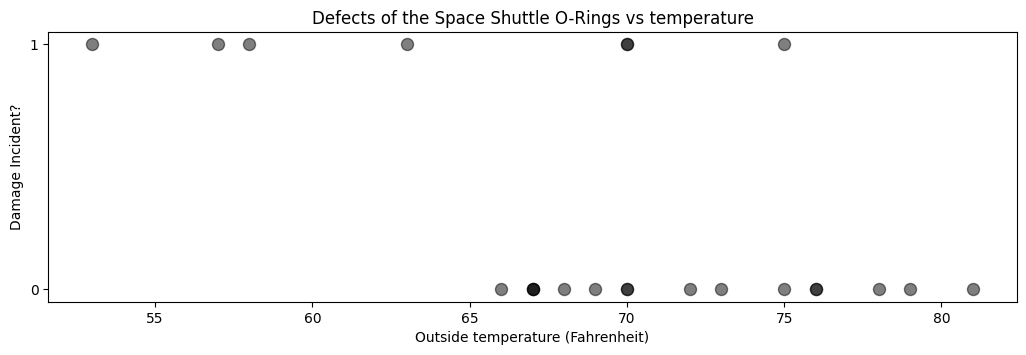

In [40]:
# Set print options and load data
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt(
    "data/challenger_data.csv", skip_header=1, usecols=[1, 2], missing_values="NA", delimiter=","
)
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# Print data
print("Temp (F), O-Ring failure?")
print(challenger_data)

# Stateless plotting
fig, ax = plt.subplots(figsize=(12.5, 3.5))
ax.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k", alpha=0.5)
ax.set_yticks([0, 1])
ax.set_ylabel("Damage Incident?")
ax.set_xlabel("Outside temperature (Fahrenheit)")
ax.set_title("Defects of the Space Shuttle O-Rings vs temperature")

It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it $p(t)$, that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

In this model, $\beta$ is the variable we are uncertain about. Below is the function plotted for $\beta = 1, 3, -5$.

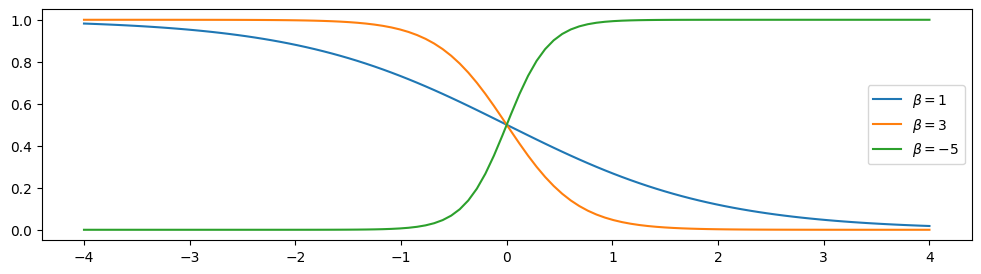

In [41]:
def logistic(x, beta):
    return 1.0 / (1.0 + jnp.exp(beta * x))


x = jnp.linspace(-4, 4, 100)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, logistic(x, 1), label=r"$\beta = 1$")
ax.plot(x, logistic(x, 3), label=r"$\beta = 3$")
ax.plot(x, logistic(x, -5), label=r"$\beta = -5$")
ax.legend()

But something is missing. In the plot of the logistic function, the probability changes only near zero, but in our data above the probability changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are below, with differing $\alpha$.

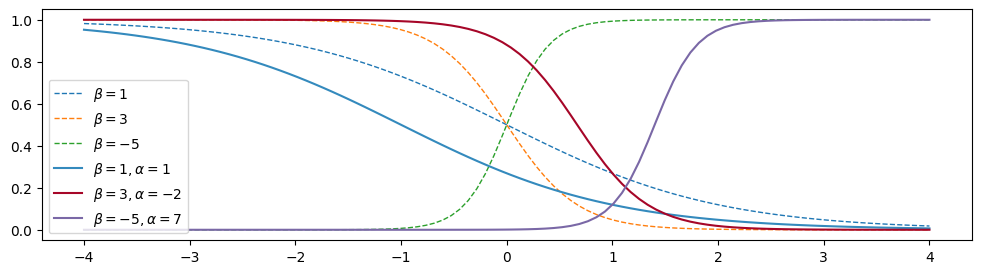

In [42]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + jnp.exp(jnp.dot(beta, x) + alpha))


x = jnp.linspace(-4, 4, 100)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
ax.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
ax.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

ax.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$", color="#348ABD")
ax.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$", color="#A60628")
ax.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$", color="#7A68A6")

ax.legend(loc="lower left")


Adding a constant term $\alpha$ amounts to shifting the curve left or right (hence why it is called a *bias*).

Let's start modeling this in PyMC. The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*, introduced next.

### Normal distributions

A Normal random variable, denoted $X \sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean, $\mu$, and the *precision*, $\tau$. Those familiar with the Normal distribution already have probably seen $\sigma^2$ instead of $\tau^{-1}$. They are in fact reciprocals of each other. The change was motivated by simpler mathematical analysis and is an artifact of older Bayesian methods. Just remember: the smaller $\tau$, the larger the spread of the distribution (i.e. we are more uncertain); the larger $\tau$, the tighter the distribution (i.e. we are more certain). Regardless, $\tau$ is always positive. 

The probability density function of a $N( \mu, 1/\tau)$ random variable is:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right) $$

We plot some different density functions below. 

Text(0.5, 1.0, 'Probability distribution of three different Normal random variables')

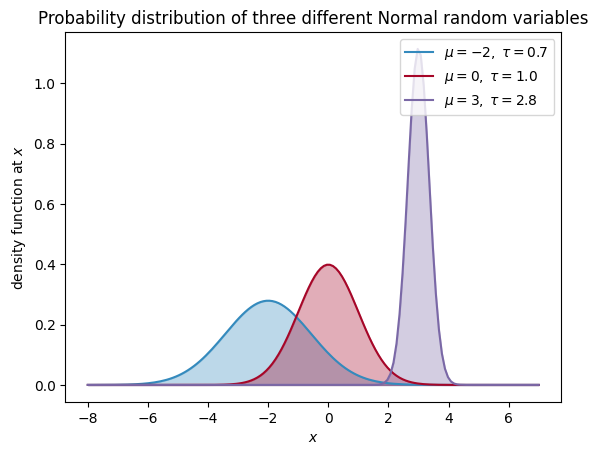

In [44]:
x = jnp.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (0.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

fig, ax = plt.subplots()
for _mu, _tau, _color in parameters:
    scale = 1.0 / _tau
    normal_dist = dist.Normal(_mu, scale)
    y = jnp.exp(normal_dist.log_prob(x))
    ax.plot(x, y, label=rf"$\mu = {_mu},\;\tau = {_tau:.1f}$", color=_color)
    ax.fill_between(x, y, color=_color, alpha=0.33)

ax.legend(loc="upper right")
ax.set_xlabel("$x$")
ax.set_ylabel("density function at $x$")
ax.set_title("Probability distribution of three different Normal random variables")


A Normal random variable can be take on any real number, but the variable is very likely to be relatively close to $\mu$. In fact, the expected value of a Normal is equal to its $\mu$ parameter:

$$ E[ X | \mu, \tau] = \mu$$

and its variance is equal to the inverse of $\tau$:

$$Var( X | \mu, \tau ) = \frac{1}{\tau}$$



Below we continue our modeling of the Challenger space craft:

In [45]:
temperature = jnp.array(challenger_data[:, 0])
D = jnp.array(challenger_data[:, 1]).astype(int)


# Model definition
def logistic_regression_model(temperature, D=None):
    beta = numpyro.sample("beta", dist.Normal(0, jnp.sqrt(1 / 0.001)))
    alpha = numpyro.sample("alpha", dist.Normal(0, jnp.sqrt(1 / 0.001)))
    p = 1.0 / (1.0 + jnp.exp(beta * temperature + alpha))
    numpyro.sample("bernoulli_obs", dist.Bernoulli(probs=p), obs=D)

In [46]:
# Run MCMC
rng_key = random.PRNGKey(0)
kernel = NUTS(logistic_regression_model)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=10000)
mcmc.run(rng_key, temperature=temperature, D=D)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 12000/12000 [10:10<00:00, 19.66it/s, 3 steps of size 4.33e-02. acc. prob=0.96]   


In [49]:
# Extract and reshape
alpha_samples = posterior_samples["alpha"].reshape(-1, 1)
beta_samples = posterior_samples["beta"].reshape(-1, 1)

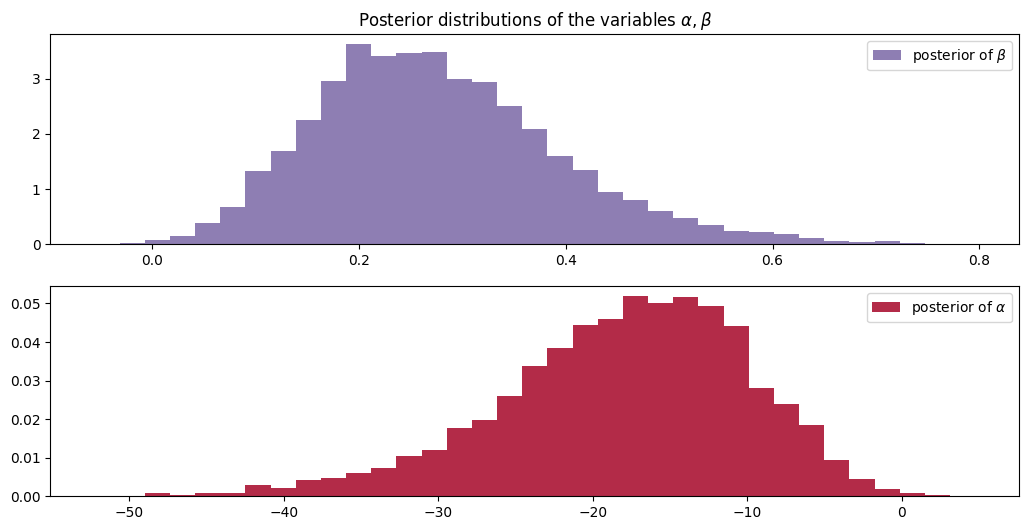

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12.5, 6))
ax1.hist(
    beta_samples,
    bins=35,
    alpha=0.85,
    color="#7A68A6",
    histtype="stepfilled",
    density=True,
    label=r"posterior of $\beta$",
)
ax1.set_title(r"Posterior distributions of the variables $\alpha, \beta$")
ax1.legend()

ax2.hist(
    alpha_samples,
    bins=35,
    alpha=0.85,
    color="#A60628",
    histtype="stepfilled",
    density=True,
    label=r"posterior of $\alpha$",
)
ax2.legend()

Text(0.5, 1.0, 'posterior of $\\alpha$')

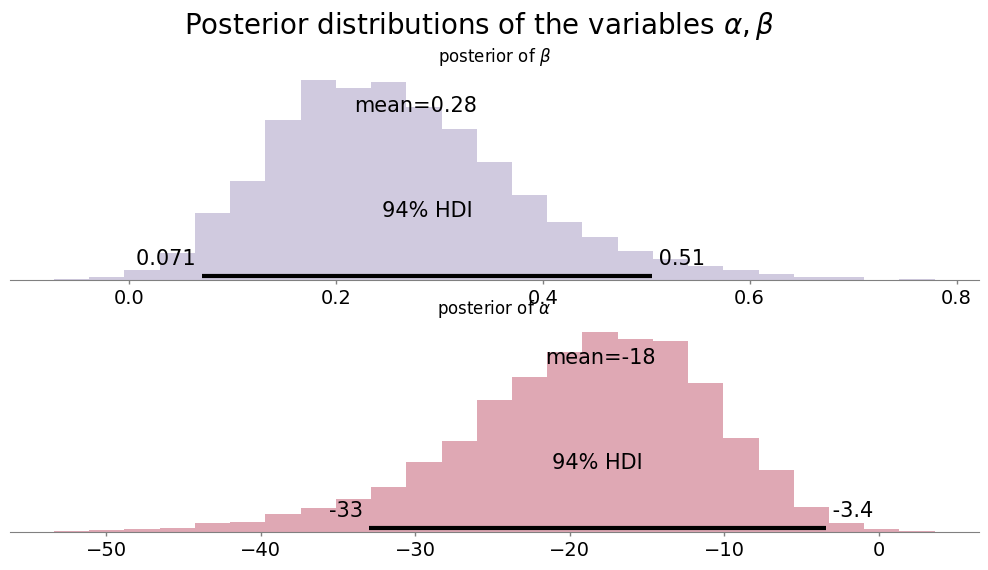

In [51]:
# ArviZ posterior plots
idata = az.from_numpyro(mcmc)

fig, ax = plt.subplots(2, 1, figsize=(12.5, 6))
az.plot_posterior(idata, var_names=["beta"], kind="hist", bins=25, color="#7A68A6", ax=ax[0])
az.plot_posterior(idata, var_names=["alpha"], kind="hist", bins=25, color="#A60628", ax=ax[1])
fig.suptitle(r"Posterior distributions of the variables $\alpha, \beta$", fontsize=20)
ax[0].set_title(r"posterior of $\beta$")
ax[1].set_title(r"posterior of $\alpha$")

All samples of $\beta$ are greater than 0. If instead the posterior was centered around 0, we may suspect that $\beta = 0$, implying that temperature has no effect on the probability of defect. 

Similarly, all $\alpha$ posterior values are negative and far away from 0, implying that it is correct to believe that $\alpha$ is significantly less than 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).  

Next, let's look at the *expected probability* for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for $p(t_i)$.

In [52]:
t = jnp.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

Text(0.5, 0, 'temperature')

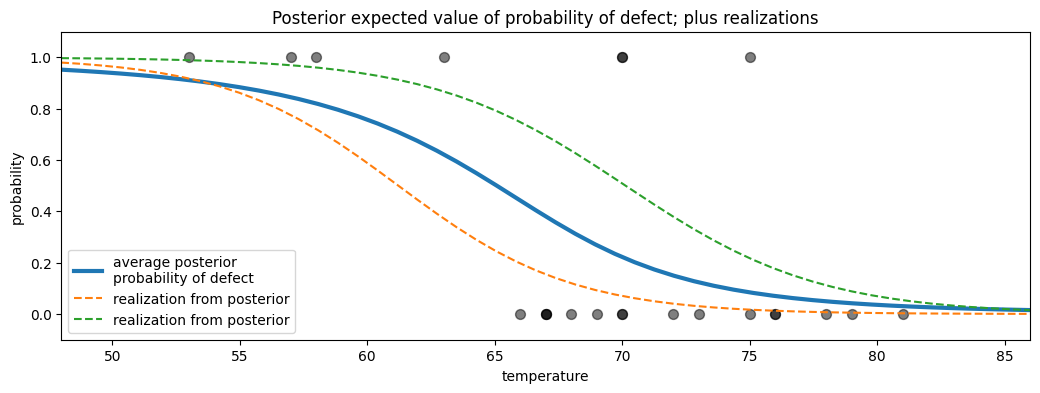

In [53]:
fig, ax = plt.subplots(figsize=(12.5, 4))

ax.plot(
    t,
    mean_prob_t,
    lw=3,
    label="average posterior \nprobability of defect",
)

ax.plot(t, p_t[0, :], ls="--", label="realization from posterior")
ax.plot(t, p_t[-2, :], ls="--", label="realization from posterior")

ax.scatter(temperature, D, color="k", s=50, alpha=0.5)

ax.set_title("Posterior expected value of probability of defect; plus realizations")
ax.legend(loc="lower left")
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(t.min(), t.max())
ax.set_ylabel("probability")
ax.set_xlabel("temperature")


Above we also plotted two possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 20000 possible dotted lines together.


An interesting question to ask is for what temperatures are we most uncertain about the defect-probability? Below we plot the expected value line **and** the associated 95% intervals for each temperature. 

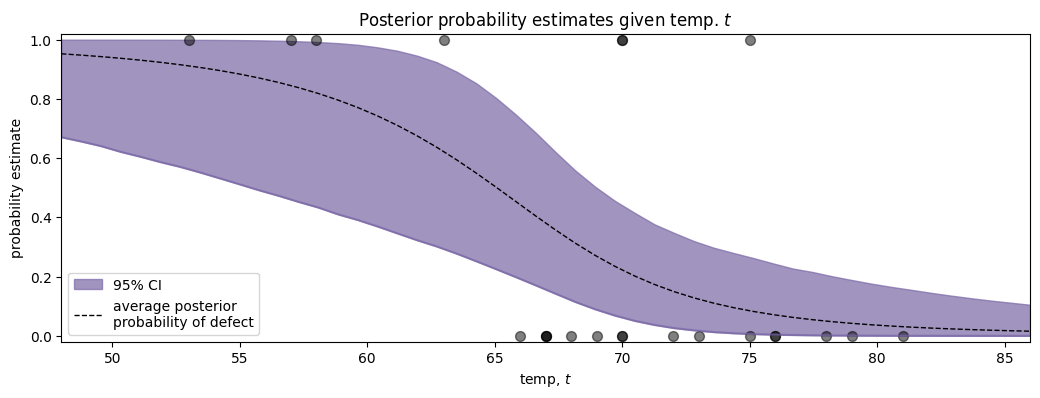

In [54]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Compute 2.5% and 97.5% quantiles across the posterior samples (axis=0: across samples for each t)
qs = jnp.quantile(p_t, jnp.array([0.025, 0.975]), axis=0)

fig, ax = plt.subplots(figsize=(12.5, 4))

# Fill between the quantiles to visualize the 95% credible interval
ax.fill_between(t[:, 0], qs[0], qs[1], alpha=0.7, color="#7A68A6", label="95% CI")

# Plot the lower bound of the CI for clarity
ax.plot(t[:, 0], qs[0], color="#7A68A6", alpha=0.7)

# Plot the mean posterior probability
ax.plot(t, mean_prob_t, lw=1, ls="--", color="k", label="average posterior \nprobability of defect")

# Overlay the original data
ax.scatter(temperature, D, color="k", s=50, alpha=0.5)

# Configure plot aesthetics
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-0.02, 1.02)
ax.set_xlabel("temp, $t$")
ax.set_ylabel("probability estimate")
ax.set_title("Posterior probability estimates given temp. $t$")
ax.legend(loc="lower left")


The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over [0,1] quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

Text(0.5, 0, 'probability of defect occurring in O-ring')

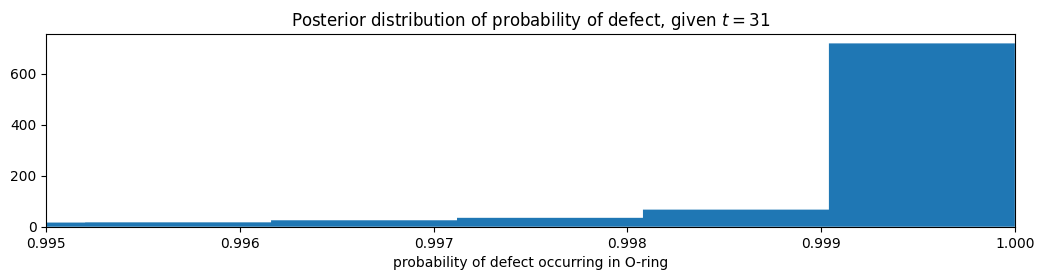

In [55]:
fig, ax = plt.subplots(figsize=(12.5, 2.5))

# Compute logistic probability for t=31 across all posterior samples
prob_31 = 1.0 / (1.0 + jnp.exp(beta_samples * 31 + alpha_samples))

# Plot histogram of probabilities
ax.hist(prob_31, bins=1000, density=True, histtype="stepfilled")

# Configure plot
ax.set_xlim(0.995, 1)
ax.set_title("Posterior distribution of probability of defect, given $t = 31$")
ax.set_xlabel("probability of defect occurring in O-ring")


### Is our model appropriate?

The skeptical reader will say "You deliberately chose the logistic function for $p(t)$ and the specific priors. Perhaps other functions or priors will give different results. How do I know I have chosen a good model?" This is absolutely true. To consider an extreme situation, what if I had chosen the function $p(t) = 1,\; \forall t$, which guarantees a defect always occurring: I would have again predicted disaster on January 28th. Yet this is clearly a poorly chosen model. On the other hand, if I did choose the logistic function for $p(t)$, but specified all my priors to be very tight around 0, likely we would have very different posterior distributions. How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data (which if we recall is a *fixed* stochastic variable) with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

Previously in this Chapter, we simulated artificial dataset for the SMS example. To do this, we sampled values from the priors. We saw how varied the resulting datasets looked like, and rarely did they mimic our observed dataset. In the current example,  we should sample from the *posterior* distributions to create *very plausible datasets*. Luckily, our Bayesian framework makes this very easy. We only need to create a new `Stochastic` variable, that is exactly the same as our variable that stored the observations, but minus the observations themselves. If you recall, our `Stochastic` variable that stored our observed data was:

    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)

Hence we create:
    
    simulated_data = pm.Bernoulli("simulation_data", p)

Let's simulate 10 000:

In [70]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]


# Model definition
def model(temperature, D=None):
    beta = numpyro.sample("beta", dist.Normal(0, jnp.sqrt(1 / 0.001)))
    alpha = numpyro.sample("alpha", dist.Normal(0, jnp.sqrt(1 / 0.001)))
    logits = beta * temperature + alpha
    p = 1.0 / (1.0 + jnp.exp(-logits))
    numpyro.deterministic("p", p)
    numpyro.sample("bernoulli_obs", dist.Bernoulli(probs=p), obs=D)
    numpyro.sample("bernoulli_sim", dist.Bernoulli(probs=p))


# Run inference
rng_key = random.PRNGKey(0)
kernel = DiscreteHMCGibbs(NUTS(model))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000)
mcmc.run(rng_key, temperature=temperature, D=D)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 11000/11000 [09:09<00:00, 20.01it/s, 3 steps of size 3.34e-02. acc. prob=0.95]  


In [71]:
posterior_samples.keys()

dict_keys(['alpha', 'bernoulli_sim', 'beta', 'p'])

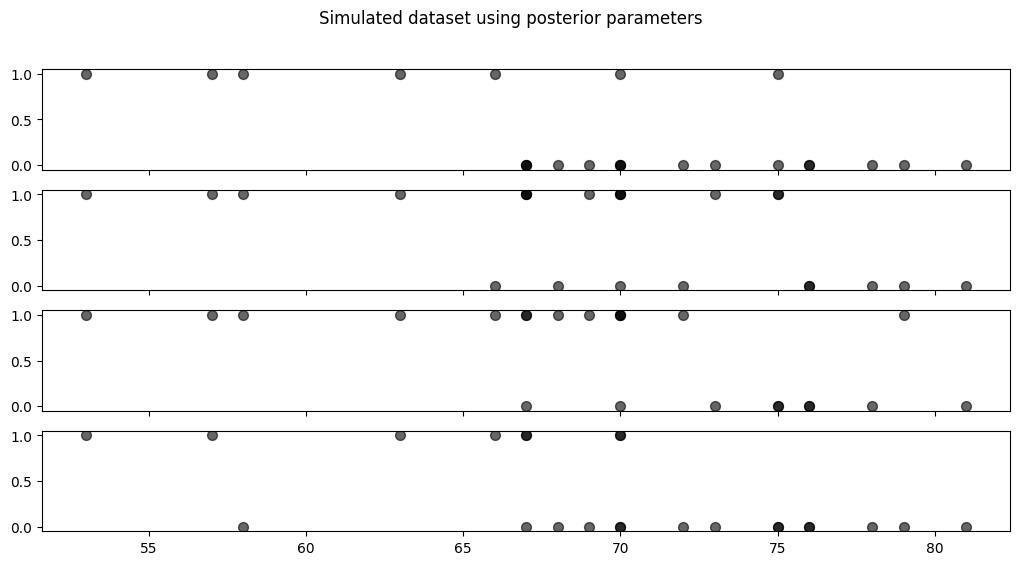

In [86]:
idata = az.from_numpyro(mcmc)

# Extract simulations
simulations = idata.posterior["bernoulli_sim"].stack(sample=("chain", "draw")).values

# Plot simulations
fig, axs = plt.subplots(4, 1, figsize=(12.5, 6), sharex=True)
fig.suptitle("Simulated dataset using posterior parameters")
for i in range(4):
    axs[i].scatter(temperature, simulations.T[1000 * i, :], color="k", s=50, alpha=0.6)

Note that the above plots are different (if you can think of a cleaner way to present this, please send a pull request and answer [here](http://stats.stackexchange.com/questions/53078/how-to-visualize-bayesian-goodness-of-fit-for-logistic-regression)!).

We wish to assess how good our model is. "Good" is a subjective term of course, so results must be relative to other models. 

We will be doing this graphically as well, which may seem like an even less objective method. The alternative is to use *Bayesian p-values*. These are still subjective, as the proper cutoff between good and bad is arbitrary. Gelman emphasises that the graphical tests are more illuminating [7] than p-value tests. We agree.

The following graphical test is a novel data-viz approach to logistic regression. The plots are called *separation plots*[8]. For a suite of models we wish to compare, each model is plotted on an individual separation plot. I leave most of the technical details about separation plots to the very accessible [original paper](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-5907.2011.00525.x), but I'll summarize their use here.

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P( \;\text{Defect} = 1 | t, \alpha, \beta )$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. For example, for the model we used above:

In [93]:
posterior_probability = simulations.mean(axis=1)
print("posterior prob of defect | realized defect ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

posterior prob of defect | realized defect 
0.45                     |   0
0.23                     |   1
0.28                     |   0
0.32                     |   0
0.38                     |   0
0.15                     |   0
0.12                     |   0
0.23                     |   0
0.84                     |   1
0.63                     |   1
0.22                     |   1
0.05                     |   0
0.37                     |   0
0.91                     |   1
0.40                     |   0
0.09                     |   0
0.22                     |   0
0.03                     |   0
0.07                     |   0
0.05                     |   0
0.08                     |   1
0.07                     |   0
0.82                     |   1


Next we sort each column by the posterior probabilities:

In [94]:
ix = jnp.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb | defect 
0.03  |   0
0.05  |   0
0.05  |   0
0.07  |   0
0.07  |   0
0.08  |   1
0.09  |   0
0.12  |   0
0.15  |   0
0.22  |   1
0.22  |   0
0.23  |   1
0.23  |   0
0.28  |   0
0.32  |   0
0.37  |   0
0.38  |   0
0.40  |   0
0.45  |   0
0.63  |   1
0.82  |   1
0.84  |   1
0.91  |   1


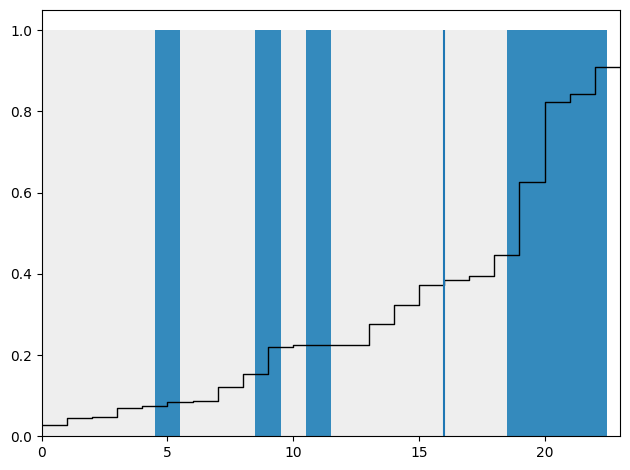

In [95]:
from separation_plot import separation_plot

separation_plot(posterior_probability, D)

The snaking-line is the sorted probabilities, blue bars denote defects, and empty space (or grey bars for the optimistic readers) denote non-defects.  As the probability rises, we see more and more defects occur. On the right hand side, the plot suggests that as the posterior probability is large (line close to 1), then more defects are realized. This is good behaviour. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions. 

The black vertical line is the expected number of defects we should observe, given this model. This allows the user to see how the total number of events predicted by the model compares to the actual number of events in the data.

It is much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. the perfect model, which predicts the posterior probability to be equal 1 if a defect did occur.
2. a completely random model, which predicts random probabilities regardless of temperature.
3. a constant model:  where $P(D = 1 \; | \; t) = c, \;\; \forall t$. The best choice for $c$ is the observed frequency of defects, in this case 7/23.  


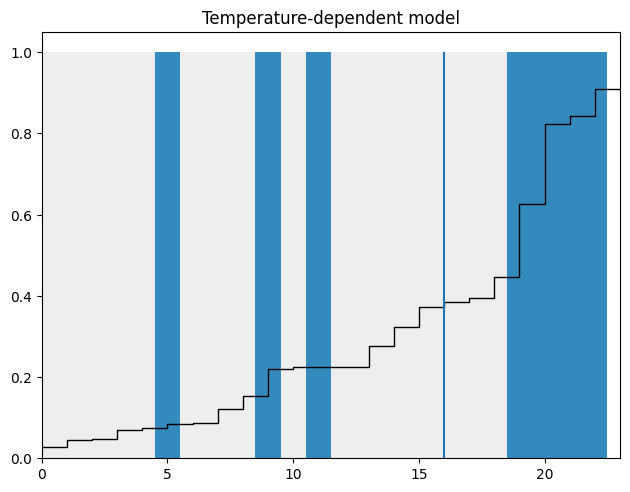

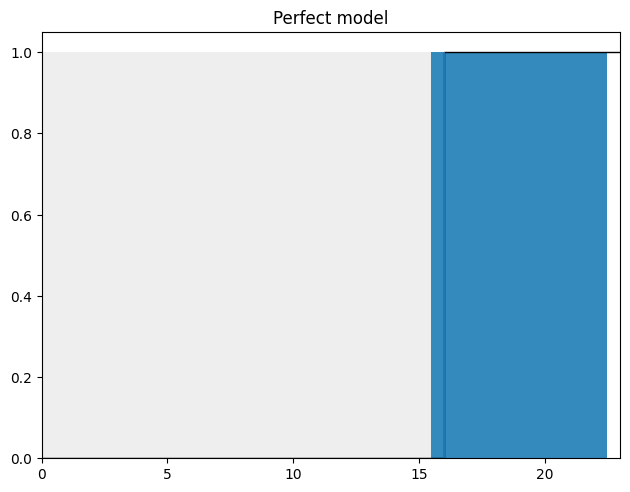

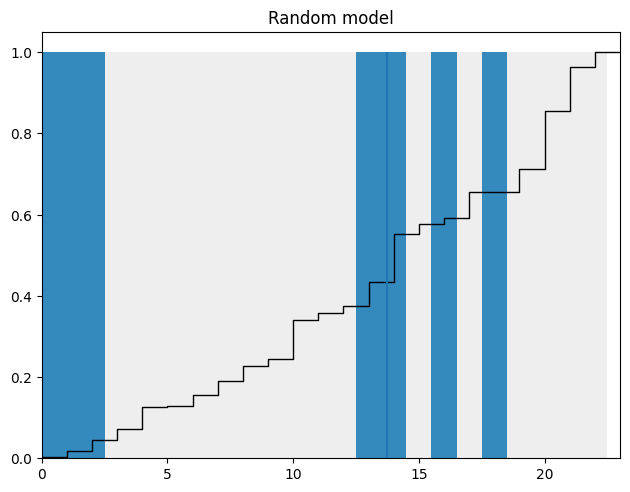

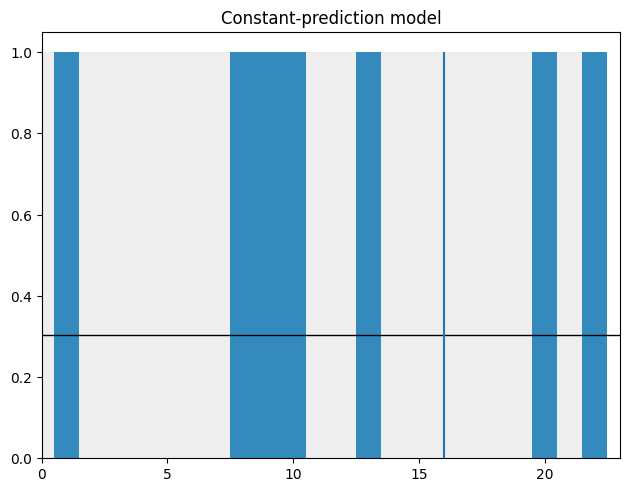

In [96]:
# Our temperature-dependent model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p = D
separation_plot(p, D)
plt.title("Perfect model")

# random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# constant model
constant_prob = 7.0 / 23 * np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

In the random model, we can see that as the probability increases there is no clustering of defects to the right-hand side. Similarly for the constant model.

The perfect model, the probability line is not well shown, as it is stuck to the bottom and top of the figure. Of course the perfect model is only for demonstration, and we cannot infer any scientific inference from it.